# SLU12 - Validation metrics for regression: Learning Notebook

In this notebook, you will learn about:
* [Mean Absolute Error (MAE)]()
* [Mean Squared Error (MSE)]()
* [Root Mean Squared Error (RMSE)]()
* [Coefficient of Determination (R²)]()
* [Adjusted R²]()
* [Regularization]()

In SLU9, you were introduced to one of the most intuitive and used regression models. You were also introduced to function ($J$) that measured how good the linear regression model was. In this SLU, we will take a look at that function, and others, more in-depth. 

But, before we start, there is something we should make it clear first. It will be very usual, while studying & practising data science, that you will hear/read these two words: **loss** and **metric**. Both of the refer to functions that evaluate the **quality** of a model. Sometimes, people will use both as they are the same thing. But really important differences between them:
* **Loss** is the function that your model will minimize;
* **Metric** is the function that you really want to use to evaluate how good your model is.

Sometimes, the loss and metric functions are the same (example: linear regression). But other times, e.g. in classification, the metric will be really different from the loss. In this notebook,  **we will focus on metrics**.

## Mean Absolute Error (MAE)

$$MAE = \frac{1}{N} \sum_{n=1}^N \left|y_n - \hat{y}_n\right|$$

In [1]:
mae = lambda y, y_hat: np.abs(y - y_hat).mean()

* The lower, the better.
* It is less sensible to outliers than MSE (the next metric).
* The output can be interpreted as the expected error measured in the same units as the target.
* It can be used as both a metric and a loss function. There are some important caveats to take into consideration when doing using MAE as a loss function: (a) the number of solutions, (b) large jumps in the values of the parameters and (c) not having a derivative when MAE is 0.

## Mean Squared Error (MSE)

In SLU9, we already explored this metric

$$MSE = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$

In [2]:
mse = lambda y, y_hat: ((y - y_hat)**2).mean()

* The lower, the better.
* MSE can be used as both a metric and a loss function (e.g. linear regression).
* It is sensible to outliers in its' original form.
* The units of the metric are not the same as the ones used in the target. For example, if you are predicting house prices, i.e. the output is \$, then the output would have units like \$².

## Root Mean Squared Error (RMSE)

$$RMSE = \sqrt{MSE}$$

In [3]:
rmse = lambda y, y_hat: np.sqrt(mse(y, y_hat))

* The lower, the better.
* Its' output can be interpreted as having the same units as the targets.
* MSE can be used as both a metric and a loss function. If fact, if we computed its partial derivative is $\frac{\partial RMSE}{\partial \hat{y}} = \frac{1}{2 \sqrt{MSE}} MSE$
* Similar to MSE, RMSE will also be sensitive to outliers.

## Coefficient of Determination (R²)

R² compares how better your regression model is when compared with a predictor that outputs just the mean of the targets

$$\bar{y} = \frac{1}{N} \sum_{n=1}^N y_n$$

$$R² = 1 - \frac{MSE(y, \hat{y})}{MSE(y, \bar{y})} 
= 1 - \frac{\frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2}{\frac{1}{N} \sum_{n=1}^N (y_n - \bar{y})^2}
= 1 - \frac{\sum_{n=1}^N (y_n - \hat{y}_n)^2}{\sum_{n=1}^N (y_n - \bar{y})^2}$$

In [4]:
r2 = lambda y, y_hat: 1 - (mse(y, y_hat) / mse(y, np.mean(y)))

The higher the R², the more sure you are that the independent variables you used explain how the dependent variable changes. For example, if you got a R² of 0.7, you can say that the set of features you used are able to explain 70% of the target variable..

The higher R² you can get is 1. If you get R² = 0, it means that your model doesn't explain anything in the target by using the features you selected. If you get R² < 0, you are probably suffering too much with overshooting (remember the SGDRegressor example in SLU9?). Also, another reason for having R² < 0 is that the model you used doesn't make sense for that data you have.

Also, when using R², there are something important [caveats](https://en.wikipedia.org/wiki/Coefficient_of_determination#Caveats) to take into account. One of the caveats is that, depending on the model, using more features can inflate the R² when, in fact, those features are really noisy, meaning the model is actually fitting to the noise.

## Adjusted R²

In order to take into account the addition os useless variables, we can use the adjusted R² score

$$R_{adj}^2 = 1 - \frac{N - 1}{N - K - 1} (1 - R^2)$$

where $N$ is the number of observations in the training dataset and K is the number of features your model is using.

In [5]:
adjusted_r2 = lambda y, y_hat, N, K: 1 - ((N - 1) / (N - K - 1)) * (1 - r2(y, y_hat))

## Regularization

> *(...) regularization is the process of introducing additional information in order to solve an ill-posed problem or to avoid overfitting.*

Throughout your jouney into data science, it will be very common for you to deal with problems stemming from having a small dataset, noisy features and, also, a high sparsity level in that dataset (i.e. a lot of entries in your dataset will be "missing"). Many of the models we usually have can suffer greatly under these circumstances, specially if they have a lot of parameters to be estimated (i.e. many degrees of freedom). To cope with them, several techniques were created. Here are two examples: 
* Early Stopping: divide your data into train, validation and test sets. For each optimization iteration, measure the error on the validation set. If it keeps decreasing, continue with the process. If it increases, stop the optimization process. This is a method used in iterative optimization algorithms based on gradients (e.g. stochastic gradient descent).
* Weights growth restrictions and shrinkage through the use of $L_2$ and $L_1$ regularizers. These methods are very popular and can apply to closed form optimization algorithms like normal equations, iterative optimatization algorithmns based on gradients and tree-based models.

In this notebook, we will explore the second type of methods: $L_1$ and $L_2$ regularizers. 

In SLU9, we described the loss function of the linear regression as

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2$$

**This loss function has a (serious) problem: the optimization methods will adapt, as much as they can, the parameters to the training set.**

To illustrate this, let's explore the following example:

In [6]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

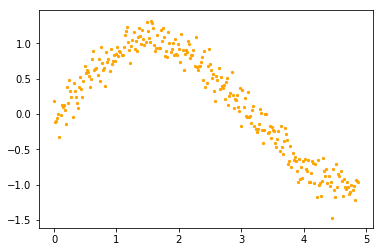

In [7]:
from utils import create_dataset

data = create_dataset()
original_data = data.copy()

plt.scatter(data['x'], data['y'], c='orange', s=5)

As you can see, this dataset is noisy but has a clear relation between the input and the target. Let's fit a simple linear regression.

Text(0.5,1,'Linear Regression (R²: 0.5833747720084554)')

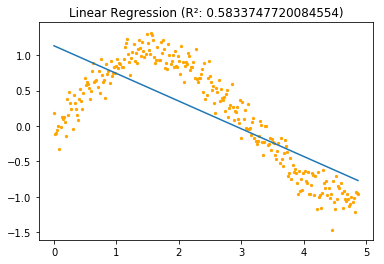

In [8]:
from sklearn.linear_model import LinearRegression

x = data.drop('y', axis=1)
y = data['y']


lr = LinearRegression(normalize=True)
lr.fit(x, y)


plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

In order to try to get a better result, let's add extra inputs: **powers of data['x']**.

          x         y       x_2
0  0.000000  0.179518  0.000000
1  0.017453 -0.113721  0.000305
2  0.034907 -0.096912  0.001218
3  0.052360 -0.061370  0.002742
4  0.069813  0.006077  0.004874


Text(0.5,1,'Linear Regression (R²: 0.8710898440178443)')

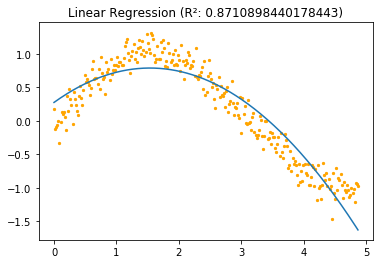

In [9]:
from utils import expand_dataset

data = expand_dataset(original_data, 3)
print(data.head(5))

x = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

We improved our R²! Let's get crazy and see what happens with many more powers

Text(0.5,1,'Linear Regression (R²: 0.9600487264796599)')

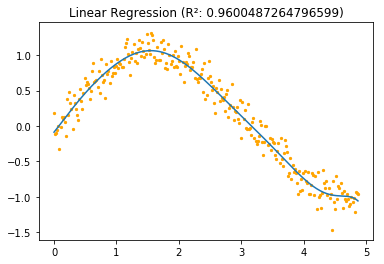

In [10]:
data = expand_dataset(original_data, 10)

x = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

Text(0.5,1,'Linear Regression (R²: 0.9623947848396236)')

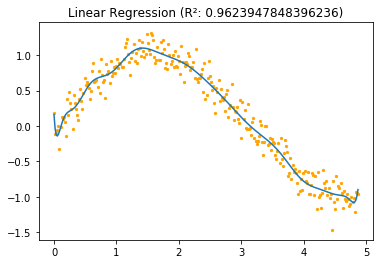

In [11]:
data = expand_dataset(original_data, 20)

x = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

Text(0.5,1,'Linear Regression (R²: 0.9567266364598261)')

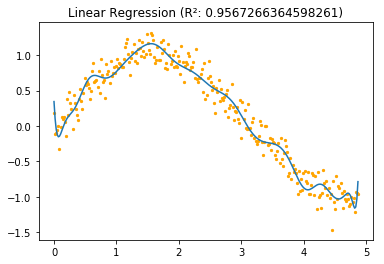

In [12]:
data = expand_dataset(original_data, 40)

x = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

Text(0.5,1,'Linear Regression (R²: 0.9613561313797037)')

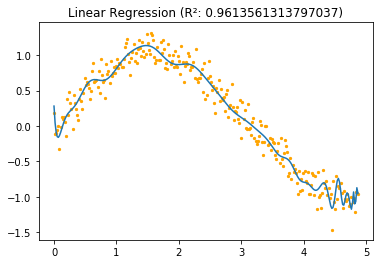

In [13]:
data = expand_dataset(original_data, 200)

x = data.drop('y', axis=1)
y = data['y']

lr = LinearRegression(normalize=True)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

You might have notice that the model, when adding a large number of this type of features, starts to fit to the noise as well!! This means that a test set will, very likely, produce a really bad R², eventhough we are increasing the R² in the training set (also, remember that issue with noise fitting and R²?). One thing that we can do is apply $L_2$ regularization in our linear model. This means changing the loss function to

$$L = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \|\beta\|_2^2 = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \sum_{k=1}^K \beta_k^2$$

In [14]:
def linear_regression_reg_l2_loss(y, y_hat, betas, lamb2):
    return ((y - y_hat) ** 2).mean() + lamb2 * (betas[1:] ** 2).sum()

where $\lambda_2$ is the strength of the regularization part. As you might have noticed, $\beta_0$ (i.e. the intercept). That is due to certain theoretical aspects related to the intercept that are completely out of scope in here. If you are interested in knowing more about them, check the discussion in [stats.exchange.com](https://stats.stackexchange.com/questions/86991/reason-for-not-shrinking-the-bias-intercept-term-in-regression) or check this **bible** called [*Elements of Statistical Learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) (there is also a MOOC for this). The idea of this loss function is that the model optimization will have to be more careful in growing the coefficients for the features or it will be penalized.

In scikit learn, SGDRegressor supports $L_2$ regularization. But, instead of using that class, let's use this example to introduce to you a new class: [Ridge](http://scikit-learn.org/0.18/modules/generated/sklearn.linear_model.Ridge.html). This class implements ridge regression or, in other words, it implements to the new loss function we have just shown you.

Text(0.5,1,'Linear Regression (R²: 0.7136076996599339)')

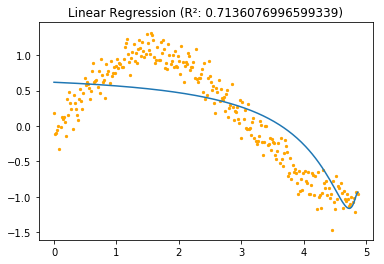

In [15]:
from sklearn.linear_model import Ridge


data = expand_dataset(original_data, 200)

x = data.drop('y', axis=1)
y = data['y']

lr = Ridge(normalize=True, alpha=2, random_state=10)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

Let's increase the number of power features and see what happen

Text(0.5,1,'Linear Regression (R²: 0.7135764533178403)')

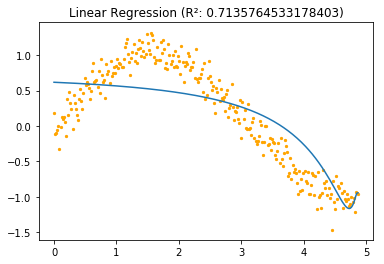

In [16]:
from sklearn.linear_model import Ridge


data = expand_dataset(original_data, 400)

x = data.drop('y', axis=1)
y = data['y']

lr = Ridge(normalize=True, alpha=2, random_state=10)
lr.fit(x, y)

plt.scatter(x['x'], data['y'], c='orange', s=5)
plt.plot(x['x'], lr.predict(x))
plt.title('Linear Regression (R²: {})'.format(lr.score(x, y)))

Interesting! Even after adding more features, we model didn't change (almost) anything! 

By the way, keep in mind that if we used the adjusted R², by this time, we would have an awful R² due to the number of useless features we have! If you don't believe us, let's check the coefficients

In [17]:
(lr.coef_ == 0).sum() / lr.coef_.shape[0]

0.43859649122807015

~44% of feature coefficients are 0! This means that those features are completely useless and, as desired, the adjusted R² would greatly penalize us!

Besides $L_2$, we also have $L_1$ regularization

$$L = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \|\beta\|_1^1 = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

which is usually called [Lasso regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). This type of regression is way more aggressive in its approach to constraining coefficient magnitude. In many real world scenarios, it is used to have just a few features with coefficients different from 0. Also, finally, we can have both $L_1$ and $L_2$ on what is called [Elastic Net regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

$$L_{L_1} = \lambda_1 \|\beta\|_1^1 = \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

$$L_{L_2} = \lambda_2 \|\beta\|_2^2 = \lambda_2 \sum_{k=1}^K \beta_k^2$$

$$L = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + L_{L_1} + L_{L_2}$$